In [204]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
import sklearn
import scipy.stats as stats
import sklearn.neighbors as neighbors
import scipy.interpolate as interpolate
from lab7.xgboost_example import X_train

In [236]:
def g_of_x(x):
    return 4.62*(np.exp(-x)-4*np.exp(-2*x)+3*np.exp(-3*x))

def MSE(y, y_hat):
    return np.mean(np.square(y-y_hat))
def generate_data(n=1000):
    x=np.random.uniform(0, 4, n)
    eps=np.random.normal(0, 0.1, n)
    y=g_of_x(x)+eps
    return x,y

In [237]:
class Regressor(object):
    def __init__(self):
        pass

    def fit(self, x, y):
        self.x = x.reshape(-1, 1)
        self.y = y.reshape(-1, 1)
        return self

    def predict(self, x):
        raise NotImplementedError("Subclasses should implement this!")

In [311]:
class NadarayaWatsonKernelRegressor(Regressor):
    def __init__(self,K,K_args):
        super().__init__()
        self.K = K(**K_args)
    
    def predict(self, x):
        N=x.shape[0]
        y_pred = np.zeros(N)
        for i in range(N):
            weights= self.K.eval(x[i],self.x)
            Y= np.dot(self.y.T,weights) / np.sum(weights)
            y_pred[i] = Y[0][0]
        return y_pred

In [312]:
class GaussianKernel:
    def __init__(self, bandwidth):
        self.bandwidth = bandwidth
    def eval(self, x, x0):
        return np.exp(-np.square(x-x0) / (2 * np.square(self.bandwidth))) / (np.sqrt(2 * np.pi) * self.bandwidth)
    
class UniformKernel:
    def __init__(self, bandwidth):
        self.bandwidth = bandwidth
    def eval(self, x, x0):
        return np.where(np.abs(x - x0) < self.bandwidth/2, 1, 0)

In [313]:
class SmoothingSpline(Regressor):
    def __init__(self, lam=0.1):
        super().__init__()
        self.lam=lam
    def fit(self, x, y):
        idx=np.argsort(x.flatten())
        self.x = x[idx]
        self.y = y[idx]
        self.spline = interpolate.make_smoothing_spline(self.x.flatten(), self.y.flatten(), lam=self.lam)
        return self
    def predict(self, x):
        return self.spline(x)

In [354]:
def plot_comparison(x_test,y_hat,y_hat_ss,y_true=False,y_test=None):
    x_test=x_test.reshape(-1,)
    idx=np.argsort(x_test)
    plt.figure(figsize=(16, 9))
    plt.title("Nadaraya-Watson Kernel Regression vs Smoothing Spline plot")
    plt.plot(x_test[idx],y_hat[idx], label="Nadaraya-Watson")
    if y_true :
        plt.plot(x_test[idx],g_of_x(x_test[idx]), label="True")
    if y_test is not None:
        plt.plot(x_test[idx],y_test[idx],label="Test")
    plt.plot(x_test[idx],y_hat_ss[idx], label="Smoothing Spline")
    plt.legend()
    plt.show()
    
    plt.figure(figsize=(16, 9))
    plt.title("Nadaraya-Watson Kernel Regression vs Smoothing Spline scatter")
    plt.scatter(x_test,y_hat, label="Nadaraya-Watson")
    if y_true:
        plt.scatter(x_test,g_of_x(x_test), label="True")
    if y_test is not None:
        plt.scatter(x_test,y_test,label="Test")
    plt.scatter(x_test,y_hat_ss, label="Smoothing Spline")
    plt.legend()
    plt.show()


In [357]:
K_args={"bandwidth": 0.1}
K=GaussianKernel
x,y=generate_data(3000)
x_train, x_test, y_train, y_test = train_test_split(x.reshape(-1, 1), y, test_size=0.2, random_state=42)
y_hat=NadarayaWatsonKernelRegressor(K, K_args).fit(x_train, y_train).predict(x_test)
y_hat_ss=SmoothingSpline(lam=0.1).fit(x_train, y_train).predict(x_test)
y_true=g_of_x(x_test)
print("ref y NWKernel", MSE(y_test, y_hat))
print("ref y SS", MSE(y_test, y_hat_ss))
print("g function NWKernel", MSE(y_true, y_hat))
print("g function SS", MSE(y_true, y_hat_ss))



ref y NWKernel 0.014292712025389965
ref y SS 0.376755843331867
g function NWKernel 0.37223353430044576
g function SS 0.0022630387677168044


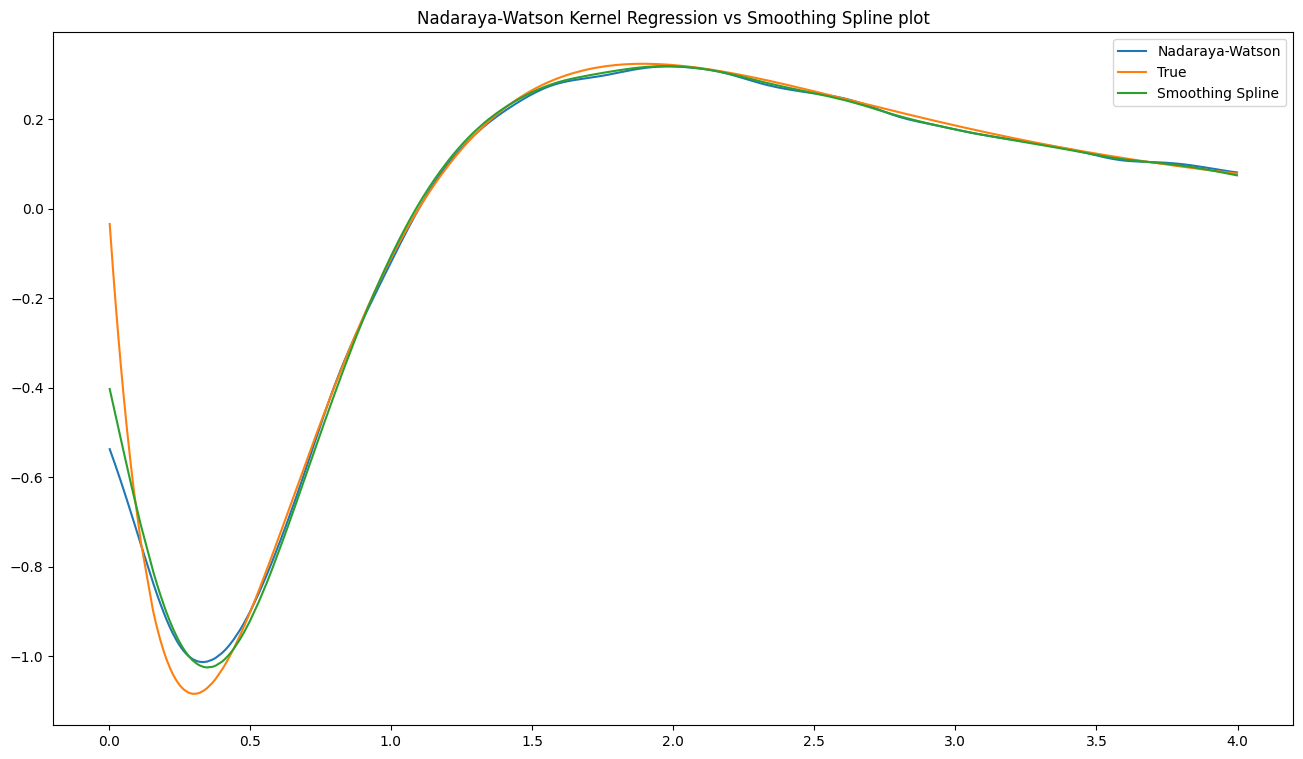

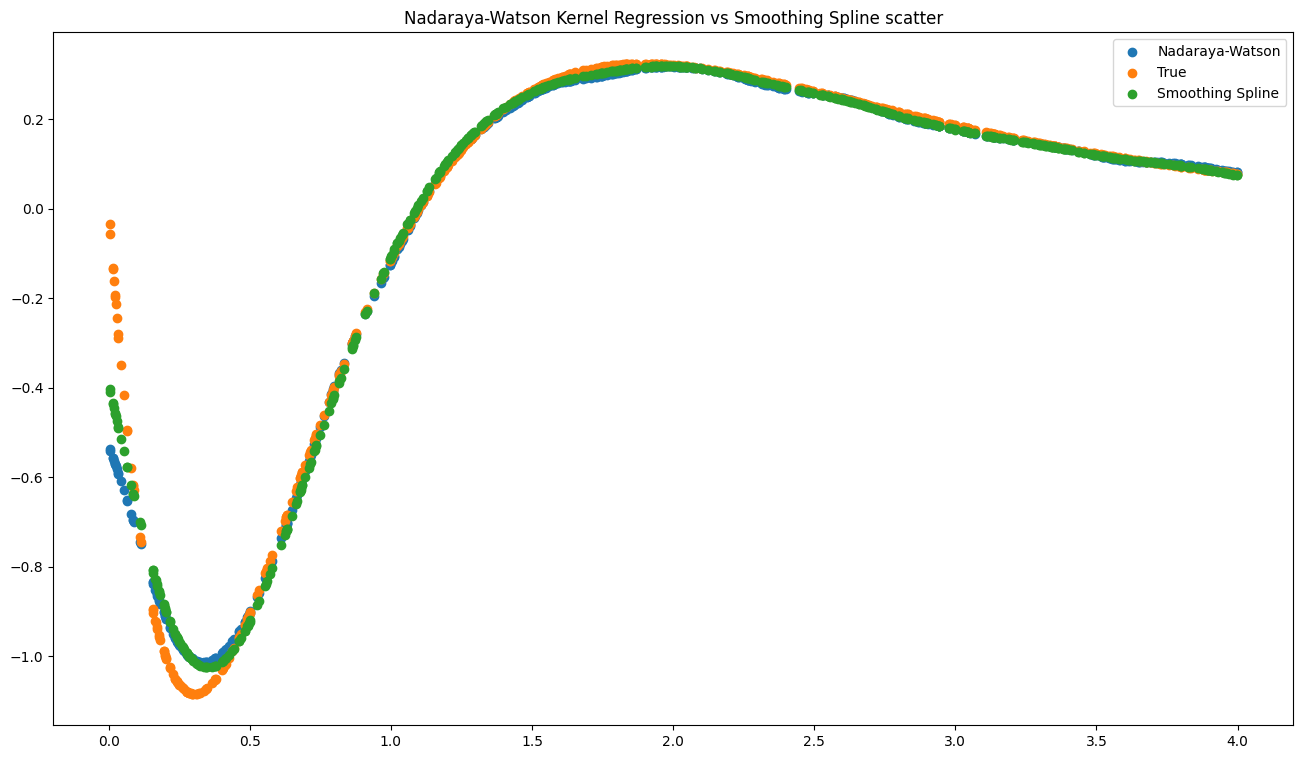

In [358]:
plot_comparison(x_test,y_hat,y_hat_ss,y_true=True)

In [363]:
def compare_MSE():
    N=np.linspace(500,3000,100).astype(int)
    K=GaussianKernel
    K_args={"bandwidth": 0.5}
    mse_nw=[]
    mse_ss=[]
    for n in N:
        x,y=generate_data(n)
        x_train, x_test, y_train, y_test = train_test_split(x.reshape(-1, 1), y, test_size=0.2)
        y_true=g_of_x(x_test)
        y_hat=NadarayaWatsonKernelRegressor(K, K_args).fit(x_train, y_train).predict(x_test)
        y_hat_ss=SmoothingSpline(lam=0.1).fit(x_train, y_train).predict(x_test)
        print("Number of samples", n)
        print("g function NWKernel", MSE(y_true, y_hat))
        print("g function SS", MSE(y_true, y_hat_ss))
        mse_nw.append(MSE(y_true, y_hat))
        mse_ss.append(MSE(y_true, y_hat_ss))
    plt.figure(figsize=(16, 9))
    plt.plot(N, mse_nw, label="Nadaraya-Watson")
    plt.plot(N, mse_ss, label="Smoothing Spline")
    plt.xlabel("Number of samples")
    plt.legend()
    plt.ylabel("MSE")
    return mse_nw, mse_ss

Number of samples 500
g function NWKernel 0.1559101713892381
g function SS 0.008265926628974183
Number of samples 525
g function NWKernel 0.26835126130063613
g function SS 0.008251191097396271
Number of samples 550
g function NWKernel 0.2530072517389191
g function SS 0.0056097313098810355
Number of samples 575
g function NWKernel 0.2705944408141088
g function SS 0.005611285746985748
Number of samples 601
g function NWKernel 0.3528525685563483
g function SS 0.0034446742616347907
Number of samples 626
g function NWKernel 0.30209144925351034
g function SS 0.004085508375331631
Number of samples 651
g function NWKernel 0.21821703567326772
g function SS 0.0014116880548926715
Number of samples 676
g function NWKernel 0.23813233824193594
g function SS 0.0032628637622692165
Number of samples 702
g function NWKernel 0.26967400755171805
g function SS 0.005386131038180327
Number of samples 727
g function NWKernel 0.3269238762906053
g function SS 0.003440279357314639
Number of samples 752
g functio

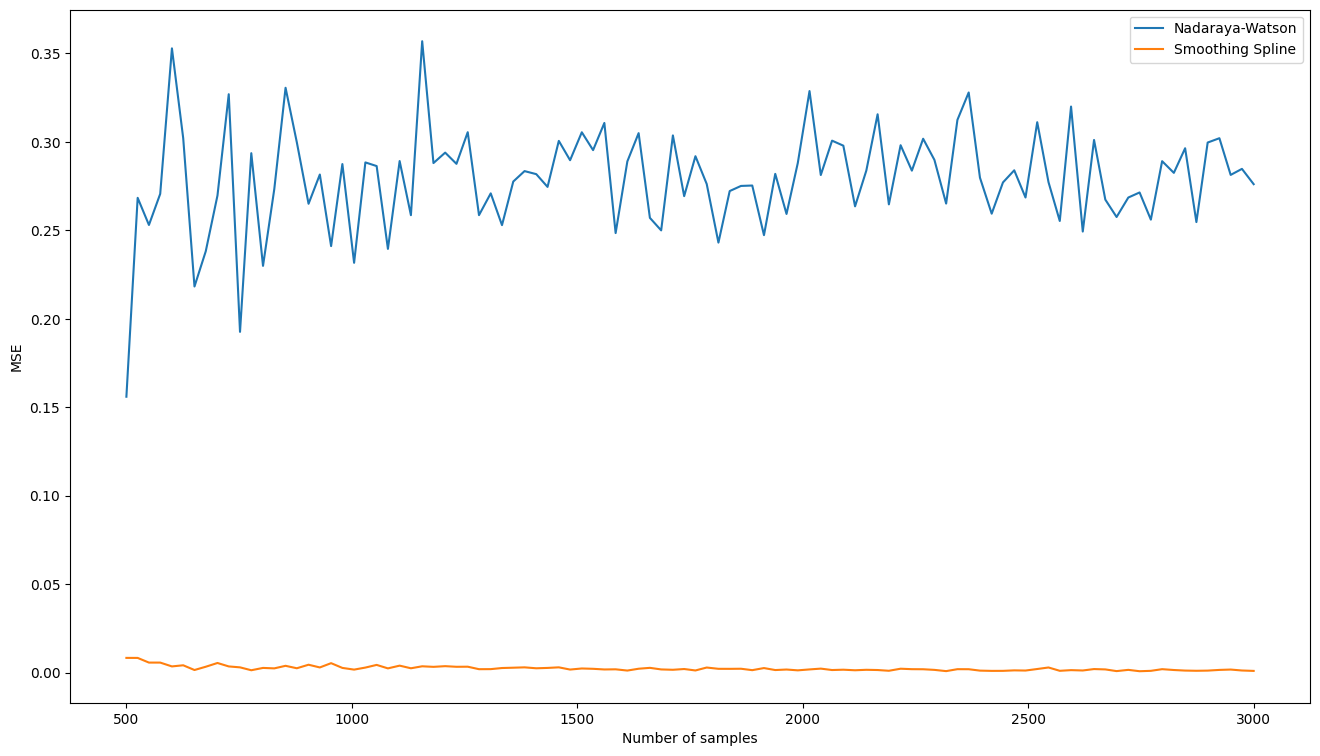

In [364]:
a,b=compare_MSE()

In [344]:
A=np.ndarray((20,3))
A[:,0]=a.reshape(-1,)
A[:,1]=b.reshape(-1,)
A[:,2]=c.reshape(-1,)

In [350]:
print((np.mean(A[:,0]-A[:,2])**2)*20)
print((np.mean(A[:,1]-A[:,2])**2)*20)

0.0072675015670877665
0.0031411401399761376
